# Text Classification mit XGBoost

In [1]:
import numpy as np # for array, linear algebra
import pandas as pd # for data processing
import matplotlib as mpl  # to visualize data
import matplotlib.pyplot as plt # to crreate stat and visualize data
import matplotlib.colors as mcolors # to visualize colors
import seaborn as sns # to visualize data
from sklearn.feature_extraction.text import TfidfVectorizer # to transfrom the text into numbers
from sklearn.metrics import * # to calculate the metrics
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import xgboost as xgb# used model

In [2]:
train_stop = pd.read_csv('../../../Data-Preparation/traindata_with_stopwords_preprocessed.csv')
test_stop = pd.read_csv('../../../Data-Preparation/testdata_with_stopwords_preprocessed.csv')

In [3]:
train_stop.head()

,Text,target,Ground_Truth_Label
0,Rise and shining lol. I'm up a few mins later ...,4,positive
1,Had a 2nd interview today. It's looking promis...,4,positive
2,@EmilyAlbracht I feel your pain!,0,negative
3,http://twitpic.com/6sdbj - 4yr old son and I w...,4,positive
4,is lonely because all my housemates have gone ...,0,negative


## Vorbereitung

In [4]:
train_stop['target'] = train_stop['target'].replace(4,1)
test_stop['target'] = test_stop['target'].replace(4,1)


In [5]:
X_train_stop = train_stop.drop(['target', 'Ground_Truth_Label'], axis=1).copy()
X_test_stop = test_stop.drop(['target'], axis=1).copy()


In [6]:
Y_train_stop = train_stop['target'].copy()
Y_test_stop = test_stop['target'].copy()


## Modelltraining mit Stopwords

In [7]:
vectorizer = TfidfVectorizer()
# astype(str) is necesarry 
X_training_stop = vectorizer.fit_transform(X_train_stop['Text'].astype(str))

X_testing_stop = vectorizer.transform(X_test_stop['Text'].astype(str))


In [9]:
model = xgb.XGBClassifier(n_jobs = -1)
model.fit(X_training_stop, Y_train_stop)

KeyboardInterrupt: 

In [ ]:
predictions_stop = model.predict(X_testing_stop)

In [ ]:
accuracy = accuracy_score(Y_test_stop, predictions_stop)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 76.15%


In [ ]:
#Definition des Suchraums
space={'max_depth': hp.quniform("max_depth", 4, 6, 1),
        'gamma': hp.uniform ('gamma', 0.1,0.7),
        'reg_alpha' : hp.quniform('reg_alpha', 20,190,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,0.9),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
def objective(space):
    clf_model_stop=xgb.XGBClassifier(
                    learning_rate= 0.2, 
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), 
                    eval_metric="auc", 
                    early_stopping_rounds=10)
    
    evaluation = [( X_training_stop, Y_train_stop), ( X_testing_stop, Y_test_stop)]
    
    clf_model_stop.fit(X_training_stop, Y_train_stop,
            eval_set=evaluation,
            verbose=False)
    

    pred = clf_model_stop.predict(X_testing_stop)
    accuracy = accuracy_score(Y_test_stop, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
rstate = np.random.default_rng(43)

trials = Trials()

best_hyperparams_stop = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                        rstate=rstate)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

In [ ]:
clf_model_stop = xgb.XGBClassifier(
                            random_state=43,
                            learning_rate=0.2,
                            objective='binary:logistic',
                            gamma=best_hyperparams_stop['gamma'],
                            max_depth=int(best_hyperparams_stop['max_depth']),
                            reg_lambda=best_hyperparams_stop['reg_lambda'],
                            reg_alpha=best_hyperparams_stop['reg_alpha'],
                            min_child_weight=best_hyperparams_stop['min_child_weight'],
                            colsample_bytree=best_hyperparams_stop['colsample_bytree'],
                            n_jobs=1)

clf_model_stop.fit(X_training_stop, Y_train_stop)

## Evaluation

In [ ]:
# calculate metrics
accuracy = accuracy_score(Y_test_stop, predictions_stop)
precision = precision_score(Y_test_stop, predictions_stop, pos_label=1)
recall = recall_score(Y_test_stop, predictions_stop, pos_label=1)
f1 = f1_score(Y_test_stop, predictions_stop, pos_label=1)

# visualize metrics
print('XGBoost with Stopwords')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print()

XGBoost with Stopwords
Accuracy: 0.76
Precision: 0.74
Recall: 0.80
F1 Score: 0.77

XGBoost without Stopwords
Accuracy: 0.71
Precision: 0.66
Recall: 0.87
F1 Score: 0.75


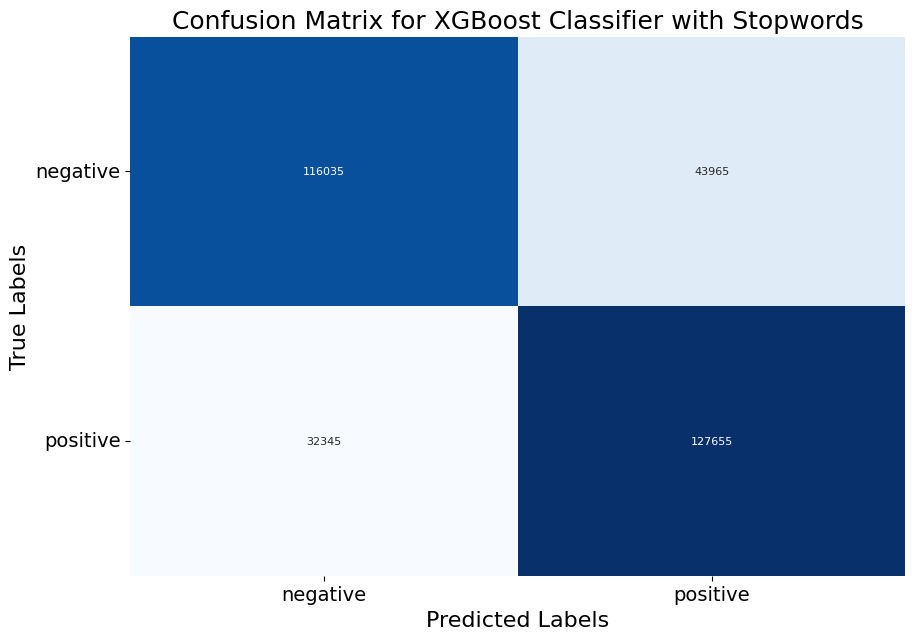

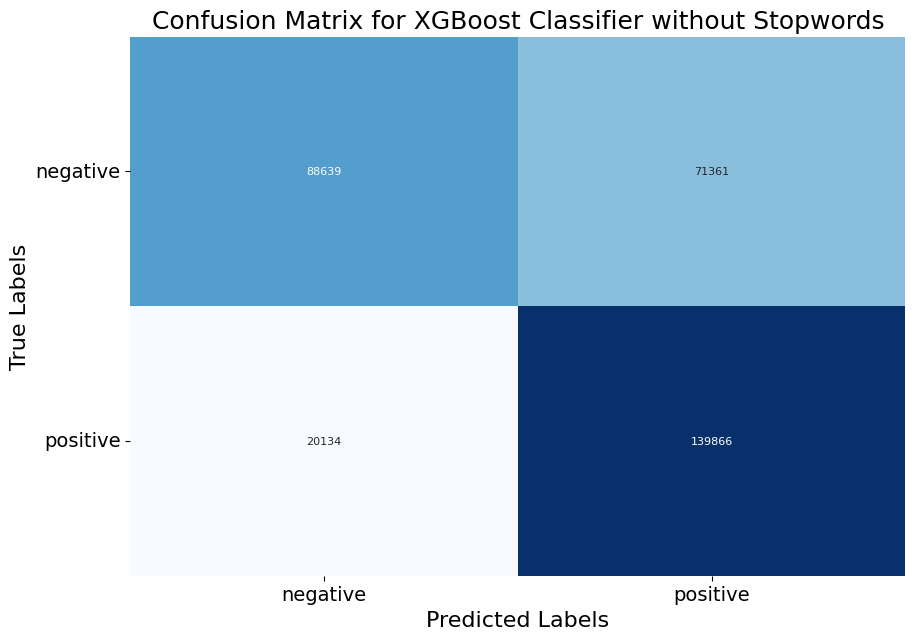

In [ ]:
cm_nb = confusion_matrix(Y_test_stop, predictions_stop)


# creation of the Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 8})
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)
plt.title('Confusion Matrix for XGBoost Classifier with Stopwords', fontsize=18)
plt.xticks(ticks=[0.5, 1.5], labels=['negative', 'positive'], fontsize=14)
plt.yticks(ticks=[0.5, 1.5], labels=['negative', 'positive'], fontsize=14, rotation=0)
plt.show()